In [6]:
import pandas as pd
import seaborn as sns
# Our scripts
import sys
sys.path.insert(0, '../src')
import microbiome_analysis as mba
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Microbiome Data

In [2]:
metadata, abundances = mba.load_data()  # load microbiome data
print(metadata.shape)
metadata.head()

(174, 87)


,Project,External ID,Participant ID,site_sub_coll,data_type,week_num,visit_num,Research Project,IntervalName,IntervalSequence,...,Did the subject withdraw from the study?,Was subject terminated by investigator?,Partial Endoscopy,race,Arthralgias,Pyoderma gangrenosum.1,Erythema nodosum.1,Uveitis.1,Partial Endoscopy.1,sex
0,C3001CSC1_BP,206615,C3001,C3001CSC1,biopsy_16S,2.0,1,ibdmdb,Screening Colonoscopy,1,...,No,No,No,White,No,No,No,No,No,Female
1,C3001CSC2_BP,206614,C3001,C3001CSC2,biopsy_16S,2.0,1,ibdmdb,Screening Colonoscopy,1,...,No,No,No,White,No,No,No,No,No,Female
2,C3002CSC1_BP,206617,C3002,C3002CSC1,biopsy_16S,0.0,1,ibdmdb,Screening Colonoscopy,1,...,No,No,No,White,No,No,No,No,No,Female
3,C3002CSC2_BP,206619,C3002,C3002CSC2,biopsy_16S,0.0,1,ibdmdb,Screening Colonoscopy,1,...,No,No,No,White,No,No,No,No,No,Female
4,C3002CSC3_BP,206616,C3002,C3002CSC3,biopsy_16S,0.0,1,ibdmdb,Screening Colonoscopy,1,...,No,No,No,White,No,No,No,No,No,Female


In [3]:
print(abundances.shape)
abundances.head()

(56, 180)


,#OTU ID,206646,224324,206619,224326,206624,219644,214995,215058,206750,...,215003,206628,219675,206728,206754,206718,206657,206670,206655,taxonomy
0,F1NS1036,1.0,3.0,0.0,2.0,125.0,6.0,3.0,20.0,4.0,...,0.0,0.0,29.0,23.0,0.0,0.0,8.0,0.0,16.0,Bacteria; __Proteobacteria; __Gammaproteobacte...
1,Unc00a9i,11.0,5.0,4.0,9.0,0.0,38.0,92.0,6.0,104.0,...,43.0,5.0,2084.0,80.0,84.0,41.0,2.0,20.0,14.0,Bacteria; __Firmicutes; __Negativicutes; __Sel...
2,Unc02f9r,379.0,5.0,5.0,147.0,0.0,634.0,0.0,38.0,270.0,...,14.0,0.0,0.0,0.0,433.0,1.0,55.0,22.0,58.0,Bacteria; __Firmicutes; __Clostridia; __Clostr...
3,Unc05bd1,1940.0,13904.0,339.0,2783.0,34.0,419.0,5263.0,1057.0,4623.0,...,653.0,0.0,880.0,3113.0,5893.0,1.0,1354.0,3.0,164.0,Bacteria; __Bacteroidetes; __Bacteroidia; __Ba...
4,UncB2490,7.0,10.0,0.0,6.0,0.0,16.0,173.0,4.0,78.0,...,96.0,5.0,113.0,12.0,48.0,5.0,31.0,18.0,0.0,Bacteria; __Firmicutes; __Bacilli; __Lactobaci...


## Using Microbiome Data to run Simulations

### Simulate using microbiome data as initial conditions

In [4]:
from model import params
params["j_P_d"] = 0.9  # modify default parameters
patterns = ['null','ident','naive','immune',
            'cycle','complete','star','barbell']
end_time = 200
results = mba.analyze(abundances, metadata, 
                      patterns, 
                      end_time, 
                      params=params)
print(results.shape)
results.to_csv('../Data/microbiome_pattern_analysis.tsv', sep='\t', index=False)

conditions:   0%|          | 0/3 [00:00<?, ?it/s]

pattern:   0%|          | 0/8 [00:00<?, ?it/s]

init:   0%|          | 0/86 [00:00<?, ?it/s]

init:   0%|          | 0/86 [00:00<?, ?it/s]

init:   0%|          | 0/86 [00:00<?, ?it/s]

init:   0%|          | 0/86 [00:00<?, ?it/s]

init:   0%|          | 0/86 [00:00<?, ?it/s]

init:   0%|          | 0/86 [00:00<?, ?it/s]

init:   0%|          | 0/86 [00:00<?, ?it/s]

init:   0%|          | 0/86 [00:00<?, ?it/s]

pattern:   0%|          | 0/8 [00:00<?, ?it/s]

init:   0%|          | 0/44 [00:00<?, ?it/s]

init:   0%|          | 0/44 [00:00<?, ?it/s]

init:   0%|          | 0/44 [00:00<?, ?it/s]

init:   0%|          | 0/44 [00:00<?, ?it/s]

init:   0%|          | 0/44 [00:00<?, ?it/s]

init:   0%|          | 0/44 [00:00<?, ?it/s]

init:   0%|          | 0/44 [00:00<?, ?it/s]

init:   0%|          | 0/44 [00:00<?, ?it/s]

pattern:   0%|          | 0/8 [00:00<?, ?it/s]

init:   0%|          | 0/44 [00:00<?, ?it/s]

init:   0%|          | 0/44 [00:00<?, ?it/s]

init:   0%|          | 0/44 [00:00<?, ?it/s]

init:   0%|          | 0/44 [00:00<?, ?it/s]

init:   0%|          | 0/44 [00:00<?, ?it/s]

init:   0%|          | 0/44 [00:00<?, ?it/s]

init:   0%|          | 0/44 [00:00<?, ?it/s]

init:   0%|          | 0/44 [00:00<?, ?it/s]

(1392, 9)


In [7]:
df = pd.read_csv('../Data/microbiome_pattern_analysis.tsv', sep='\t',
                 dtype={'pattern': 'string'},
                 keep_default_na=False)
df.head()

,total,growth_rate,has_grown,euclidian,shannon_index,bray_curtis,init,pattern,condition
0,0.090003,-0.001357,0.0,1875.213651,-4.440892e-16,4.440892e-16,0,null,CD
1,0.090004,-0.001433,0.0,536.136358,0.000000e+00,2.220446e-16,1,null,CD
2,0.090005,-0.001428,0.0,736.319763,1.776357e-15,5.551115e-16,2,null,CD
3,0.090002,-0.001383,0.0,1386.731162,8.881784e-16,5.551115e-16,3,null,CD
4,0.090004,-0.001611,0.0,48.903062,4.440892e-16,4.440892e-16,4,null,CD


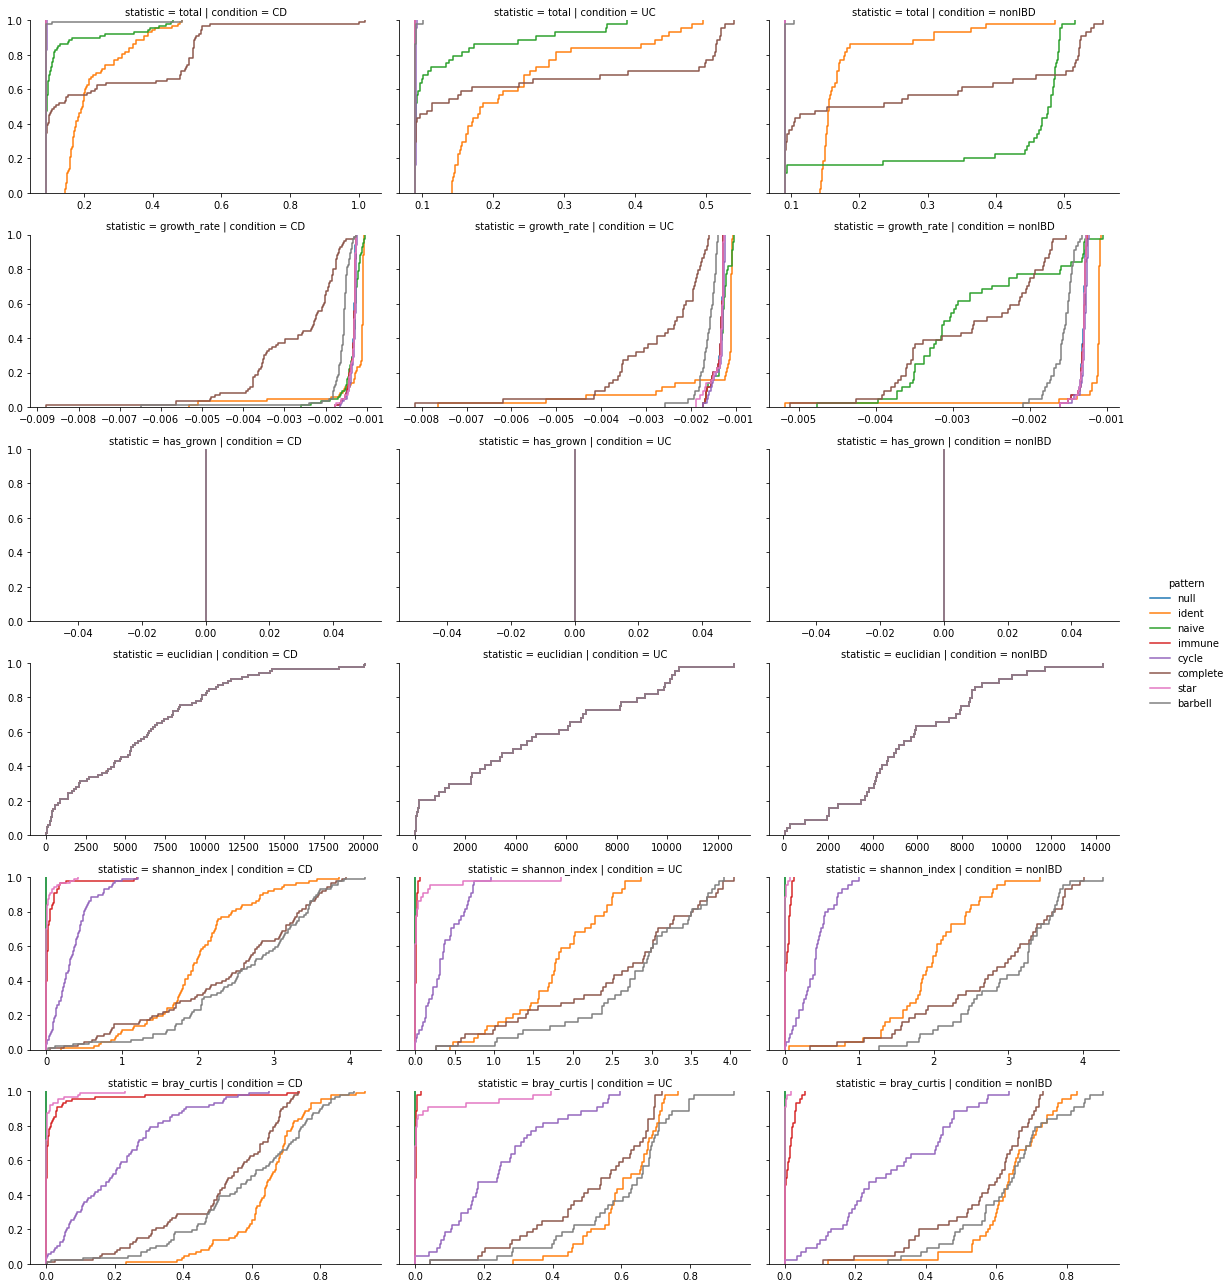

In [8]:
mba.plot_ecdf(df, '../Documents/figures/microbiome_pattern_analysis.png')